In [2]:
import pysmile
import pysmile_license
from pathlib import Path
from pysmile.learning import DataSet, EM
import itertools
from expdef import Experiment, Analytic, Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
fileName = "DBNfromAG_learned.xdsl"
numSlices = 300
dt = 1 # time step in seconds


remapOutcomes = ["workStation_compromise", "DMZ_scanIP", "historian_scanVuln", "tomcatWebServer_bruteForce", "IED1_DERfailure"]
outcomesRemap = {
    "N": "Not completed",
    "C": "Completed"
}

resultsVec = [   
        Result("workStation_compromise", 0),
        Result("DMZ_scanIP", 0),
        Result("historian_scanVuln", 0),
        Result("tomcatWebServer_bruteForce", 1),
        Result("IED1_DERfailure", 1)
    ]
experiments: list[Experiment] = [
    Experiment("No evidence", [],
    resultsVec
    )
]

In [4]:
net = pysmile.Network()
net.read_file(fileName)
# Set default inference algorithm and parameters
net.set_bayesian_algorithm(pysmile.BayesianAlgorithmType.EPIS_SAMPLING)
#pysmile.EPISParams.num_state_big
# Print default EPIS algorithm parameters
episParams = net.get_epis_params()
episParams.propagation_length = 20  # Example modification
net.set_epis_params(episParams)
print("Propagation length: ", episParams.propagation_length)
print("Num state small:", episParams.num_state_small)
print("Num state medium:", episParams.num_state_medium)
print("Num state big:", episParams.num_state_big)

Propagation length:  20
Num state small: 5
Num state medium: 8
Num state big: 20


Running experiment: No evidence
  Result for workStation_compromise
  Result for DMZ_scanIP


/tmp/ipykernel_391228/879682794.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resDf = pd.concat([resDf, pd.DataFrame([resDict])], ignore_index=True)


  Result for historian_scanVuln
  Result for tomcatWebServer_bruteForce
  Result for IED1_DERfailure
Group '0' contains nodes: ['workStation_compromise', 'DMZ_scanIP', 'historian_scanVuln']
Group '1' contains nodes: ['tomcatWebServer_bruteForce', 'IED1_DERfailure']


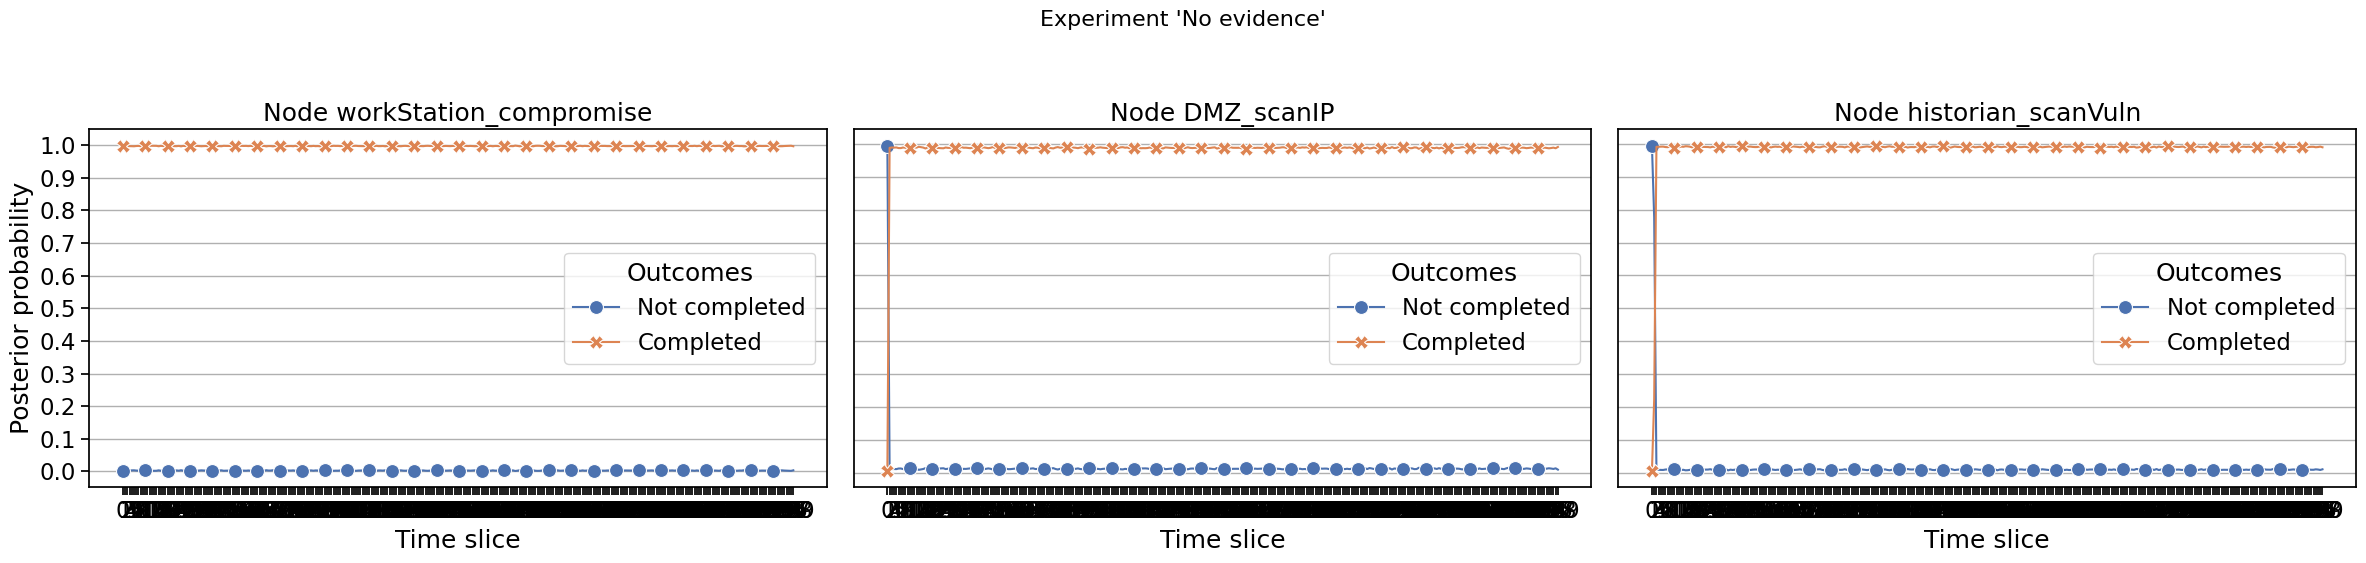

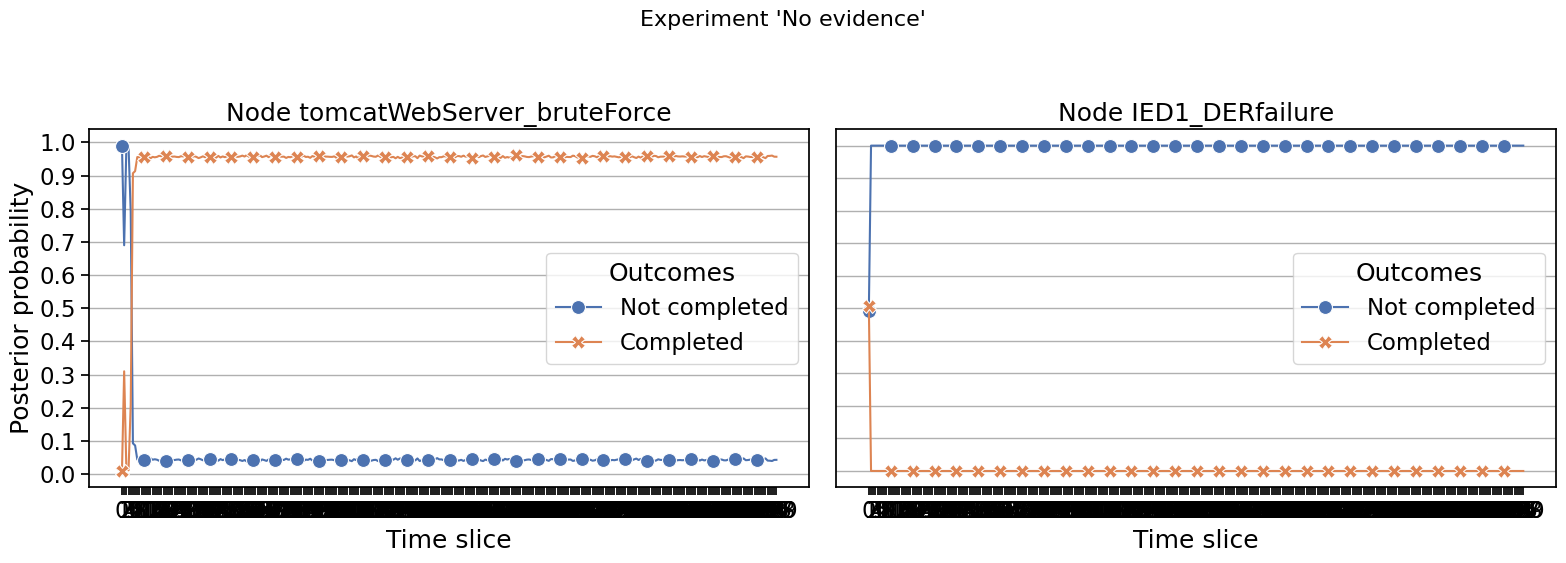

In [11]:
def plotResults(results: pd.DataFrame, exp: Experiment, save: bool = True):
    # Increase font size for better readability
    sns.set_context("notebook", font_scale=1.5)
    # Find all nodes belonging to the same group
    groups = set()
    for res in exp.results:
        groups.add(res.group)
    groups = list(groups)
    for group in groups:
        nodeIdsInGroup = [res.nodeId for res in exp.results if res.group == group]
        print(f"Group '{group}' contains nodes: {nodeIdsInGroup}")
        # Create a grid of subplots for each node in the group (at most 4x4)
        if len(nodeIdsInGroup) % 4 == 0:
            nRows = int(len(nodeIdsInGroup)/4)
        else:
            nRows = int(len(nodeIdsInGroup)/4) + 1
        if len(nodeIdsInGroup) < 4:
            nCols = len(nodeIdsInGroup) % 4
        else:
            nCols = 4
        fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=(8*nCols, 6*nRows))
        fig.suptitle(f"Experiment '{exp.name}'", fontsize=16)
        if len(nodeIdsInGroup) == 1:
            axes = [axes]
        if len(nodeIdsInGroup) > 4:
            axes = axes.flatten()
        for ax, nodeId, i in zip(axes, nodeIdsInGroup, range(len(nodeIdsInGroup))):
            node_results = results[results['nodeId'] == nodeId]
            if not node_results.empty:
                sns.lineplot(data=node_results, x="slice", y="value", hue="outcomeId", ax=ax, palette="deep", 
                             style="outcomeId", markers=True, dashes=False, markersize=10, markevery=10)
                
                ax.set_title(f"Node {nodeId}")
                ax.legend(title="Outcomes")
                ax.grid(True, axis='y')
                ax.set_yticks([i / 10 for i in range(11)])
                # Remove x-ticks and y-ticks for all but the first column and last row
                if i % nCols != 0:
                    ax.tick_params(axis="y", which='both', left=False, right=False, labelleft=False)
                    ax.set_ylabel("")
                else:
                    ax.set_ylabel("Posterior probability")
                if i < len(nodeIdsInGroup) - nCols:
                    ax.tick_params(axis="x", which='both', bottom=False, top=False, labelbottom=False)
                    ax.set_xlabel("")
                else:
                    ax.set_xlabel("Time slice")
                    ax.set_xticks(range(0, numSlices))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save:
            plt.savefig(f"plots/{exp.name}_group_{group}.png")
        else:
            plt.show()

def runExperiments(net: pysmile.Network, experiments: list[Experiment]):
    for exp in experiments:
        net.clear_all_evidence()
        print(f"Running experiment: {exp.name}")
        analytics = exp.analytics
        for analytic in analytics:
            print(f"  Setting evidence for node: {analytic.nodeId}")
            if analytic.slices is None:
                # Set static evidence: node_id, outcome_id
                net.set_evidence(analytic.nodeId, analytic.outcomeId)
            else:
                for slice_num in analytic.slices:
                    # Set temporal evidence: node_id, slice, outcome_id
                    net.set_temporal_evidence(analytic.nodeId, slice_num, analytic.outcomeId)
        # Run inference
        net.update_beliefs()
        # Plot results
        resDf = pd.DataFrame(columns=["nodeId", "slice", "outcomeId", "value"])
        for result in exp.results:
            print(f"  Result for {result.nodeId}")
            val = net.get_node_value(result.nodeId)
            # Build the results dataframe
            resDict = {}
            for i in range(numSlices):
                for outcomeId, j in zip(net.get_outcome_ids(result.nodeId), range(len(net.get_outcome_ids(result.nodeId)))):
                    numOutcomes = len(net.get_outcome_ids(result.nodeId))
                    if result.nodeId in remapOutcomes:
                        outcomeId = outcomesRemap[outcomeId]
                    resDict = {
                        "nodeId": result.nodeId,
                        "slice": i,
                        "outcomeId": outcomeId,
                        "value": val[(i * numOutcomes) + j]
                    }
                    resDf = pd.concat([resDf, pd.DataFrame([resDict])], ignore_index=True)
        plotResults(resDf, exp)

def runExperimentsFiltering(net: pysmile.Network, experiments: list[Experiment]):
    for exp in experiments:
        resDf = pd.DataFrame(columns=["nodeId", "slice", "outcomeId", "value"])
        print(f"Running experiment: {exp.name}")
        for i in range(numSlices):
            print(f"Slice: {i}")
            net.clear_all_evidence()
            analytics = exp.analytics
            for analytic in analytics:
                if analytic.slices is None:
                    # Set static evidence: node_id, outcome_id
                    net.set_evidence(analytic.nodeId, analytic.outcomeId)
                else:
                    j = 0
                    while j < len(analytic.slices) and analytic.slices[j] <= i:
                        slice_num = analytic.slices[j]
                        # Set temporal evidence up to the current time slice
                        net.set_temporal_evidence(analytic.nodeId, slice_num, analytic.outcomeId)
                        j += 1
            # Run inference
            net.update_beliefs()
            # Plot results
            for result in exp.results:
                val = net.get_node_value(result.nodeId)
                # Build the results dataframe
                resDict = {}
                for outcomeId, h in zip(net.get_outcome_ids(result.nodeId), range(len(net.get_outcome_ids(result.nodeId)))):
                    numOutcomes = len(net.get_outcome_ids(result.nodeId))
                    if result.nodeId in remapOutcomes:
                        outcomeId = outcomesRemap[outcomeId]
                    resDict = {
                        "nodeId": result.nodeId,
                        "slice": i,
                        "outcomeId": outcomeId,
                        "value": val[(i * numOutcomes) + h]
                    }
                    resDf = pd.concat([resDf, pd.DataFrame([resDict])], ignore_index=True)
        plotResults(resDf, exp)

#runExperimentsFiltering(net, experiments)
runExperiments(net, experiments)